# Basic Statistics in Medicine

To apply this work, we will consider a scenario where patients may have 2 types of diseases and may undergo 2 types of surgical procedures that can lead to complications. I applied this code for the research work of a colleague in medicine who aims to determine if there is a difference between 2 surgical procedures, namely Isoperistaltic versus Antiperistaltic, in patients with Crohn's disease and colon cancer. However, since she has not yet published her research, I cannot share her data and results; hence, we will rely on randomly generated data.

I believe that this code is highly valuable, especially in the field of medicine, as it constitutes a major part of the statistical analysis in our work.

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat


import warnings
warnings.filterwarnings("ignore")

# 1) Mean Function + Std / Normality: Shapiro / Statistical Test: T-test + U-test

* For conitnuous variables, Displays the mean and standard deviation for the entire group.
* Then, it displays the mean and standard deviation based on the values of a chosen second variable.
* Conducts a Shapiro-Wilk normality test.
    * If the distribution is normal: Student's t-test.
    * Otherwise, Mann-Whitney U-test.

In [193]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro


def func_mean_std(df, variable, variable2=None):
    
    # Moyenne et écart type de la variable pour toute la population
    mean_all = df[variable].mean()
    std_all = df[variable].std()
    
    # Impression des résultats pour toute la population
    print(f"mean_all ({variable}): {mean_all:.2f}, Std_all ({variable}): {std_all:.2f}")
    
    if variable2 is not None:
        valeurs = np.sort(df[variable2].dropna().unique())
        #values_to_compare = valeurs  # Prendre les deux premières valeurs
        
        for val in valeurs:
            group = df[variable][df[variable2] == val]
            mean = group.mean()
            std = group.std()
            print(f"Mean ({variable} | {variable2} = {val}): {mean:.2f}, Std ({variable} | {variable2} = {val}): {std:.2f}")
        # Comparaison des moyennes entre les deux premières valeurs
        group1 = df[variable][df[variable2] == valeurs[0]].dropna()
        group2 = df[variable][df[variable2] == valeurs[1]].dropna()
        
        try:
           # Test de normalité (Shapiro-Wilk)
            _, p_shapiro_group1 = shapiro(group1)
            _, p_shapiro_group2 = shapiro(group2)

            if p_shapiro_group1 > 0.05 and p_shapiro_group2 > 0.05:
                # Utilisation du test t si les deux groupes sont normaux
                t_stat, p_value = ttest_ind(group1, group2, equal_var=True)
                test_type = "t-test"
            else:
                # Utilisation du test U sinon
                t_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                test_type = "Mann-Whitney U"

            print(f"{test_type}:  ({variable} | {variable2} = {valeurs[0]} vs {valeurs[1]}): {t_stat:.2f}, P-Value: {p_value:.4f}")
        except ValueError as e:
            print(f"Error occurred for {variable2} = {val}: {e}")

# 2) Function for Categorical Variables, Ratio/%/Contingency Table/Test: Chi-square + Fisher

* For categorical variables, it displays ratios and percentages for the entire population.
* It displays ratios and percentages based on different values of a chosen second variable.
* Conducts a statistical test:
    * If the expected frequencies are <5, it performs Fisher's exact test.
    * Otherwise, it performs the Chi-square test (with Yates' Correction for 2x2 tables).

First, it's important to note that the fisher_exact function in scipy can only perform the Fisher's exact test on 2x2 contingency tables. Indeed, Fisher's exact test involves factorial calculations and generates very large numbers. However, you can use this function that I found on Stack Overflow by "Hikari Hikari," which allows you to overcome this limitation. This function has been tested and approved.

In [194]:
import math

def _dfs(mat, pos, r_sum, c_sum, p_0, p):

    (xx, yy) = pos
    (r, c) = (len(r_sum), len(c_sum))

    mat_new = []

    for i in range(len(mat)):
        temp = []
        for j in range(len(mat[0])):
            temp.append(mat[i][j])
        mat_new.append(temp)

    if xx == -1 and yy == -1:
        for i in range(r-1):
            temp = r_sum[i]
            for j in range(c-1):
                temp -= mat_new[i][j]
            mat_new[i][c-1] = temp
        for j in range(c-1):
            temp = c_sum[j]
            for i in range(r-1):
                temp -= mat_new[i][j]
            mat_new[r-1][j] = temp
        temp = r_sum[r-1]
        for j in range(c-1):
            temp -= mat_new[r-1][j]
        if temp <0:
            return
        mat_new[r-1][c-1] = temp

        p_1 = 1
        for x in r_sum:
            p_1 *= math.factorial(x)
        for y in c_sum:
            p_1 *= math.factorial(y)

        n = 0
        for x in r_sum:
            n += x
        p_1 /= math.factorial(n)

        for i in range(len(mat_new)):
            for j in range(len(mat_new[0])):
                p_1 /= math.factorial(mat_new[i][j])
        if p_1 <= p_0 + 0.00000001:
            #print(mat_new)
            #print(p_1)
            p[0] += p_1
    else:
        max_1 = r_sum[xx]
        max_2 = c_sum[yy]
        for j in range(c):
            max_1 -= mat_new[xx][j]
        for i in range(r):
            max_2 -= mat_new[i][yy]
        for k in range(min(max_1,max_2)+1):
            mat_new[xx][yy] = k
            if xx == r-2 and yy == c-2:
                pos_new = (-1, -1)
            elif xx == r-2:
                pos_new = (0, yy+1)
            else:
                pos_new = (xx+1, yy)
            _dfs(mat_new, pos_new, r_sum, c_sum, p_0, p)


def fisher_exact_HM(table):

    row_sum = []
    col_sum = []

    for i in range(len(table)):
        temp = 0
        for j in range(len(table[0])):
            temp += table[i][j]
        row_sum.append(temp)
    
    for j in range(len(table[0])):
        temp = 0
        for i in range(len(table)):
            temp += table[i][j]
        col_sum.append(temp)

    mat = [[0] * len(col_sum)] * len(row_sum)
    pos = (0, 0)

    p_0 = 1

    for x in row_sum:
        p_0 *= math.factorial(x)
    for y in col_sum:
        p_0 *= math.factorial(y)

    n = 0
    for x in row_sum:
        n += x
    p_0 /= math.factorial(n)

    for i in range(len(table)):
        for j in range(len(table[0])):
            p_0 /= math.factorial(table[i][j])

    p = [0]
    _dfs(mat, pos, row_sum, col_sum, p_0, p)

    return p[0]

In [195]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency

def calcul_ratio(df, variable, variable2=None):
    total_count = len(df)
    
    # Vérifier si la colonne contient des types de données mixtes
    if df[variable].dtype != 'str' and any(pd.to_numeric(df[variable], errors='coerce').isna()):
        # Convertir la colonne en chaînes de caractères
        df[variable] = df[variable].astype(str)
        df[variable] = df[variable].replace('nan', np.nan)

        
    # Calcul pour toutes les valeurs de variable
    valeurs = np.sort(df[variable].dropna().unique())
    ratios_all = []
    for val in valeurs:
        condition_count = (df[variable] == val).sum()
        percentage = (condition_count / total_count) * 100
        ratios_all.append(f"{val}: {condition_count} ({percentage:.2f}%)")
        
    result_all = " / ".join(ratios_all)
    print(f"ratio_all ({variable}): {result_all}")
    
    # Calcul pour chaque valeur de variable2
    if variable2 is not None:
        valeurs2 = np.sort(df[variable2].dropna().unique())
        group_counts_list = []
        for val2 in valeurs2:
            group = df[variable][df[variable2] == val2]
            group_count = len(group)
            group_counts = [len(group[group == val]) for val in valeurs]
            group_counts_list.append(group_counts)
            
            ratios = []
            for val, condition_count in zip(valeurs, group_counts):
                percentage = (condition_count / group_count) * 100
                ratios.append(f"{val}: {condition_count} ({percentage:.2f}%)")
                
            result = " / ".join(ratios)
            print(f"ratio ({variable} | {variable2} = {val2}): {result}")
        

        contingency_table = pd.DataFrame(group_counts_list, columns=valeurs, index=valeurs2)
        contingency_table = contingency_table.T
        print("Contingency Table:\n", contingency_table)
        
        try:
            if not contingency_table.empty:
                if contingency_table.shape >= (2, 2):
                    # Choix du test en fonction de la taille du tableau
                    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
                    if np.any(expected < 5):
                        contingency_table=contingency_table.T
                        contingency_table = np.array(contingency_table).tolist()
                        hh = fisher_exact_HM(contingency_table)
                        #odds_ratio, p_value = fisher_exact(contingency_table)
                        #print(f"Fisher's Exact Test: Odds Ratio: {odds_ratio:.4f}, P-Value: {p_value:.4f}") 
                        print(f"Fisher's Exact Test: P-Value: {hh:.4f}")
                    else:
                        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
                        print(f"Chi-Squared Test: Chi-Squared Statistic: {chi2_stat:.4f}, P-Value: {p_value:.4f}")
        except Exception as e:
            print(f"Error occurred for variable {col}: {e}")

# 3) Univariate and Multivariate Logistic Regression Analysis
* Univariate analysis using logistic regression.
* Then, multivariate analysis for p-value < 0.1.
* The results display has been simplified to align with what is typically found in medical publications.
* "Feature importance" graph ordered by Weight = Coefficient Value * (Max Value - Min Value) / Standard Deviation.
* For reference on feature importance, please see the following article: https://saturncloud.io/blog/how-to-get-feature-importance-in-logistic-regression-using-weights/#:~:text=In%20logistic%20regression%2C%20the%20importance,impact%20on%20the%20predicted%20outcome.

In [196]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

def analyse_uni_multi(df, variable, cible): 
    
    # Liste pour stocker les noms des variables significatives
    significant_vars = []

    # Boucle pour ajuster des modèles univariés et afficher leurs résumés
    for col in variable:
        try:
            x_univariate = sm.add_constant(df[col])
            model_univariate = sm.Logit(cible, x_univariate, missing='drop').fit()


            odds_ratios = pd.DataFrame(
            {
                "OR": np.exp(model_univariate.params),
                "Lower CI": model_univariate.conf_int()[0],
                "Upper CI": model_univariate.conf_int()[1],  
                "p_value": model_univariate.pvalues[1]
            }
            )
            #odds_ratios = np.exp(odds_ratios)
            print(odds_ratios[1:])

            #print(f"Univariate Analysis for {col}:\n", model_univariate.summary())

            if model_univariate.pvalues[col] < 0.1:
                significant_vars.append(col)
        except Exception as e:
            print(f"univariate Error occurred for variable {col}: {e}")
    
    try:
        print('significant_vars: ',significant_vars)
        # Ajuster le modèle multivarié avec les variables significatives seulement
        x_multivariate = sm.add_constant(df[significant_vars])
        model_multivariate = sm.Logit(cible, x_multivariate, missing='drop').fit()
        # model = sm.Logit(y, X).fit_regularized(method='l1', alpha=0.1)



        # afficher tableau resumé: 
        odds_ratios = pd.DataFrame(
        {
            "OR": np.exp(model_multivariate.params),
            "Lower CI": model_multivariate.conf_int()[0],
            "Upper CI": model_multivariate.conf_int()[1],      
            "p_value":model_multivariate.pvalues
        }
        )
        #odds_ratios = np.exp(odds_ratios)
        print('=' * 50, "multivariate",'=' * 80 )
        print('=' * 50, "Analyse simplifiee",'=' * 80 )
        print(odds_ratios[1:])
        # Afficher le résumé de l'analyse multivariable
        print('=' * 50, "Analyse complete",'=' * 80 )
        print("\nMultivariate Analysis Summary:\n", model_multivariate.summary())
        
        # Calculer les poids pour chaque variable
        coefficients = model_multivariate.params[1:]  # Coefficients de votre modèle
        max_values = df[significant_vars].max(axis=0)  # Max value pour chaque variable
        min_values = df[significant_vars].min(axis=0)  # Min value pour chaque variable
        std_values = df[significant_vars].std(axis=0)  # Standard deviation pour chaque variable

        weights = coefficients * (max_values - min_values) / std_values

        # Trier les poids en ordre descendant pour obtenir les variables les plus importantes
        sorted_idx = np.argsort(weights)[::-1]
        sorted_weights = weights[sorted_idx]
        sorted_vars = [significant_vars[i] for i in sorted_idx]
        
        # Utiliser une palette de couleurs Seaborn
        colors = sns.color_palette("pastel")
        # Créer le graphique
        fig, ax = plt.subplots(figsize=(10, 6))  # Ajuster la taille de la figure
        bars = ax.barh(sorted_vars, sorted_weights, color=colors)

        # Ajouter des étiquettes de valeur à côté des barres
        for bar in bars:
            yval = bar.get_y() + bar.get_height() / 2
            ax.text(bar.get_width(), yval, round(bar.get_width(), 2), va='center', color='black', fontsize=10)

        ax.set_title("Feature Importances based on Weights", fontsize=14)
        ax.set_xlabel("Weight", fontsize=12)
        ax.set_ylabel("Variable", fontsize=12)
        ax.spines['top'].set_visible(False)  # Cacher le bord supérieur de la figure
        ax.spines['right'].set_visible(False)  # Cacher le bord droit de la figure
        ax.grid(axis='x', linestyle='--', alpha=0.7)  # Ajouter une grille en pointillés

        fig.tight_layout()
        plt.show()

    except Exception as e:
            print(f" mutlivariate Error occurred for variable {col}: {e}")

# 4) Custom Encoding

* A little bonus: logistic regression analysis requires encoded data.
* However, the issue with Scikit-Learn's LabelEncoder function is that it encodes missing values as well.
* The solution lies in this function, which encodes the values of a variable while ignoring missing values.

In [197]:
import pandas as pd

def custom_label_encoding(df, variable_categorique):
    # Créez un dictionnaire pour stocker les mappings
    mappings = {}
    
    # Supposons que 'variable_categorique' est votre liste de variables catégoriques
    for variable in variable_categorique:
        # Créez un dictionnaire vide pour cette variable
        label_mapping = {}
        
        # Obtenez la liste unique des valeurs (en ignorant les NaN)
        unique_values = df[variable].dropna().unique()
        
        # Créez une map de chaque valeur unique vers un entier
        for i, value in enumerate(unique_values):
            label_mapping[value] = i
        
        # Ajoutez le mapping au dictionnaire principal
        mappings[variable] = label_mapping
        
        # Appliquez la transformation à la colonne
        df[variable] = df[variable].map(label_mapping)
    
    return df, mappings

# Appelez la fonction avec votre DataFrame et la liste de variables catégoriques
# df, mappings = custom_label_encoding(df, variable_categorique)

# let's try

# Generate random data

In [198]:
import pandas as pd
import numpy as np

n = 1000 
np.random.seed(42)

# continuous variable
Wb = np.random.uniform(5, 25, n)  # white blood cell *1000
Hb = np.random.uniform(8, 16, n)  # hemoglobin
Crp = np.random.uniform(0, 180, n)  # Crp
BMI = np.random.uniform(15, 50, n) # Body mass index

#categorcial variable
disease = np.random.choice([0, 1], n) #2 illnesses the patient may suffer from
sexe = np.random.choice([0, 1], n)
medical_history = np.random.choice([0, 1], n)
surgical_history = np.random.choice([0, 1], n)
surgical_procedure = np.random.choice([0, 1], n)
surgical_complication = np.random.choice([0, 1], n)


df = pd.DataFrame({'Wb': Wb, 'Hb': Hb,'Crp':Crp,'BMI':BMI,'disease':disease,
'sexe': sexe, 'medical_history': medical_history, 'surgical_history': surgical_history,
'surgical_procedure':surgical_procedure, 'surgical_complication':surgical_complication})

df.head()

,Wb,Hb,Crp,BMI,disease,sexe,medical_history,surgical_history,surgical_procedure,surgical_complication
0,12.490802,9.481063,47.107023,38.544605,1,0,0,1,0,1
1,24.014286,12.335208,44.456184,42.883849,0,1,1,0,0,0
2,19.639879,14.983567,163.125824,23.766376,1,0,0,1,0,0
3,16.973170,13.857799,44.918316,36.870593,0,1,1,0,0,0
4,8.120373,14.452489,48.950951,35.011109,0,0,1,0,0,1


## First, we will study our variables according to the 2 diseases

In [199]:
numerical_variables = ['Wb', 'Hb', 'Crp', 'BMI']
categorical_variables = ['sexe', 'medical_history', 'surgical_history', 'surgical_procedure','surgical_complication']

### for numerical variables

In [200]:
# Utilisation de la fonction
for col in numerical_variables:
    print('-' * 100)  # Ligne de séparation
    print(f"Variable: {col}")
    print('-' * 20) 
    func_mean_std(df, col, 'disease')

----------------------------------------------------------------------------------------------------
Variable: Wb
--------------------
mean_all (Wb): 14.81, Std_all (Wb): 5.84
Mean (Wb | disease = 0): 14.90, Std (Wb | disease = 0): 5.76
Mean (Wb | disease = 1): 14.71, Std (Wb | disease = 1): 5.92
Mann-Whitney U:  (Wb | disease = 0 vs 1): 127489.00, P-Value: 0.5851
----------------------------------------------------------------------------------------------------
Variable: Hb
--------------------
mean_all (Hb): 12.06, Std_all (Hb): 2.34
Mean (Hb | disease = 0): 12.02, Std (Hb | disease = 0): 2.38
Mean (Hb | disease = 1): 12.09, Std (Hb | disease = 1): 2.29
Mann-Whitney U:  (Hb | disease = 0 vs 1): 122701.00, P-Value: 0.6154
----------------------------------------------------------------------------------------------------
Variable: Crp
--------------------
mean_all (Crp): 90.43, Std_all (Crp): 52.32
Mean (Crp | disease = 0): 91.18, Std (Crp | disease = 0): 52.24
Mean (Crp | disease = 

### for categorical variables

In [201]:
# Utilisation de la fonction
for col in categorical_variables:
    print('-' * 100)  # Ligne de séparation
    print(f"Variable: {col}")
    print('-' * 30)
    calcul_ratio(df, col, 'disease')

----------------------------------------------------------------------------------------------------
Variable: sexe
------------------------------
ratio_all (sexe): 0: 495 (49.50%) / 1: 505 (50.50%)
ratio (sexe | disease = 0): 0: 249 (50.10%) / 1: 248 (49.90%)
ratio (sexe | disease = 1): 0: 246 (48.91%) / 1: 257 (51.09%)
Contingency Table:
      0    1
0  249  246
1  248  257
Chi-Squared Test: Chi-Squared Statistic: 0.0988, P-Value: 0.7533
----------------------------------------------------------------------------------------------------
Variable: medical_history
------------------------------
ratio_all (medical_history): 0: 489 (48.90%) / 1: 511 (51.10%)
ratio (medical_history | disease = 0): 0: 238 (47.89%) / 1: 259 (52.11%)
ratio (medical_history | disease = 1): 0: 251 (49.90%) / 1: 252 (50.10%)
Contingency Table:
      0    1
0  238  251
1  259  252
Chi-Squared Test: Chi-Squared Statistic: 0.3289, P-Value: 0.5663
--------------------------------------------------------------------

## Then, let's study our variables for a single disease (df[df['disease'] == 0]) according to surgical_procedure

In [202]:
numerical_variables = ['Wb', 'Hb', 'Crp', 'BMI']
categorical_variables = ['sexe', 'medical_history', 'surgical_history','surgical_complication']

### for numerical variables

In [203]:
# Utilisation de la fonction
for col in numerical_variables:
    print('-' * 100)  # Ligne de séparation
    print(f"Variable: {col}")
    print('-' * 20) 
    func_mean_std(df[df['disease'] == 0], col, 'surgical_procedure')

----------------------------------------------------------------------------------------------------
Variable: Wb
--------------------
mean_all (Wb): 14.90, Std_all (Wb): 5.76
Mean (Wb | surgical_procedure = 0): 14.73, Std (Wb | surgical_procedure = 0): 5.79
Mean (Wb | surgical_procedure = 1): 15.05, Std (Wb | surgical_procedure = 1): 5.75
Mann-Whitney U:  (Wb | surgical_procedure = 0 vs 1): 29888.00, P-Value: 0.5459
----------------------------------------------------------------------------------------------------
Variable: Hb
--------------------
mean_all (Hb): 12.02, Std_all (Hb): 2.38
Mean (Hb | surgical_procedure = 0): 12.09, Std (Hb | surgical_procedure = 0): 2.39
Mean (Hb | surgical_procedure = 1): 11.95, Std (Hb | surgical_procedure = 1): 2.38
Mann-Whitney U:  (Hb | surgical_procedure = 0 vs 1): 31871.00, P-Value: 0.5257
----------------------------------------------------------------------------------------------------
Variable: Crp
--------------------
mean_all (Crp): 91.18,

### for categorical variables

In [204]:
# Utilisation de la fonction
for col in categorical_variables:
    print('-' * 100)  # Ligne de séparation
    print(f"Variable: {col}")
    print('-' * 30)
    calcul_ratio(df[df['disease'] == 0], col, 'surgical_procedure')

----------------------------------------------------------------------------------------------------
Variable: sexe
------------------------------
ratio_all (sexe): 0: 249 (50.10%) / 1: 248 (49.90%)
ratio (sexe | surgical_procedure = 0): 0: 123 (50.83%) / 1: 119 (49.17%)
ratio (sexe | surgical_procedure = 1): 0: 126 (49.41%) / 1: 129 (50.59%)
Contingency Table:
      0    1
0  123  126
1  119  129
Chi-Squared Test: Chi-Squared Statistic: 0.0509, P-Value: 0.8216
----------------------------------------------------------------------------------------------------
Variable: medical_history
------------------------------
ratio_all (medical_history): 0: 238 (47.89%) / 1: 259 (52.11%)
ratio (medical_history | surgical_procedure = 0): 0: 118 (48.76%) / 1: 124 (51.24%)
ratio (medical_history | surgical_procedure = 1): 0: 120 (47.06%) / 1: 135 (52.94%)
Contingency Table:
      0    1
0  118  120
1  124  135
Chi-Squared Test: Chi-Squared Statistic: 0.0839, P-Value: 0.7720
------------------------

# finally, we test the univariate and multivariate analysis depending on the variable 'surgical_complication'

We recreate our data base to add some correlations in order to test the multivariate analysis

In [205]:
import pandas as pd
import numpy as np

n = 1000 
np.random.seed(42)

# continuous variable
Wb = np.random.uniform(5, 25, n)  # white blood cell *1000
Hb = np.random.uniform(8, 16, n)  # hemoglobin
Crp = np.random.uniform(0, 180, n)  # Crp
BMI = np.random.uniform(15, 50, n) # Body mass index

#categorcial variable
disease = np.random.choice([0, 1], n) #2 illnesses the patient may suffer from
sexe = np.random.choice([0, 1], n)
medical_history = np.random.choice([0, 1], n)
surgical_history = np.random.choice([0, 1], n)
surgical_procedure = np.random.choice([0, 1], n)
surgical_complication = np.random.choice([0, 1], n)

# We create some correlations with the target variable in order to test the multivariate analysis.
Hb = Hb + 0.2 * surgical_complication
surgical_history = surgical_history - 0.2 * surgical_complication
surgical_procedure = surgical_procedure + 0.2 * surgical_complication


df = pd.DataFrame({'Wb': Wb, 'Hb': Hb,'Crp':Crp,'BMI':BMI,'disease':disease,
'sexe': sexe, 'medical_history': medical_history, 'surgical_history': surgical_history,
'surgical_procedure':surgical_procedure, 'surgical_complication':surgical_complication})

df.head()

,Wb,Hb,Crp,BMI,disease,sexe,medical_history,surgical_history,surgical_procedure,surgical_complication
0,12.490802,9.681063,47.107023,38.544605,1,0,0,0.8,0.2,1
1,24.014286,12.335208,44.456184,42.883849,0,1,1,0.0,0.0,0
2,19.639879,14.983567,163.125824,23.766376,1,0,0,1.0,0.0,0
3,16.973170,13.857799,44.918316,36.870593,0,1,1,0.0,0.0,0
4,8.120373,14.652489,48.950951,35.011109,0,0,1,-0.2,0.2,1


In [206]:
variable_analayse = ['Wb', 'Hb', 'Crp', 'BMI', 'disease', 'sexe', 'medical_history', 'surgical_history', 'surgical_procedure']

Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
          OR  Lower CI  Upper CI   p_value
Wb  0.999703 -0.021524   0.02093  0.978149
Optimization terminated successfully.
         Current function value: 0.691019
         Iterations 4
          OR  Lower CI  Upper CI   p_value
Hb  1.057192  0.002458  0.108775  0.040306
Optimization terminated successfully.
         Current function value: 0.691693
         Iterations 3
          OR  Lower CI  Upper CI   p_value
Crp  0.99795 -0.004429  0.000324  0.090529
Optimization terminated successfully.
         Current function value: 0.692541
         Iterations 3
           OR  Lower CI  Upper CI  p_value
BMI  0.993174 -0.019231  0.005533   0.2783
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
               OR  Lower CI  Upper CI   p_value
disease  0.952991 -0.296095  0.199795  0.703488
Optimization terminated successfully.
         Cur

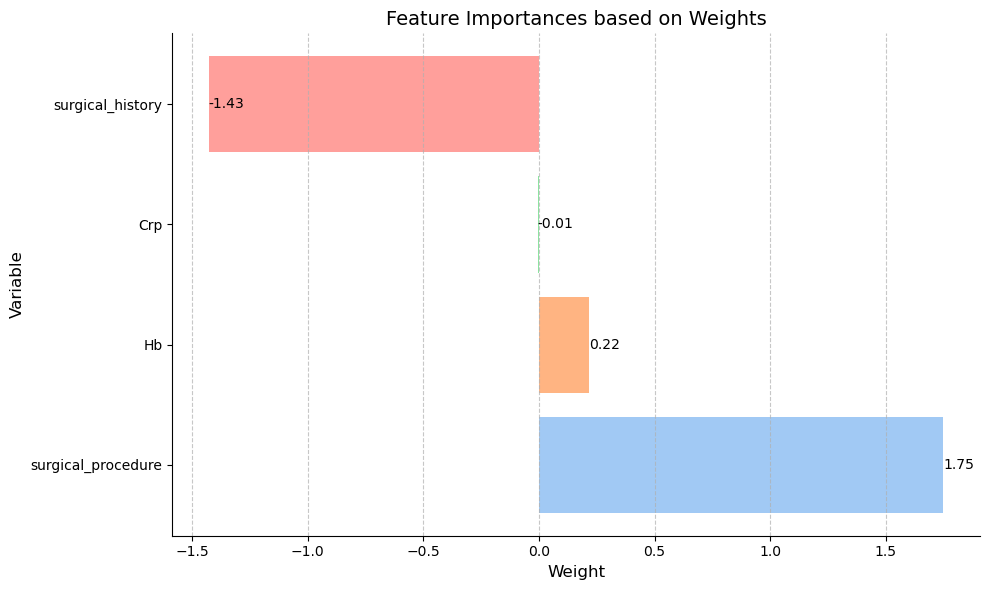

In [207]:
analyse_uni_multi(df, variable_analayse,df['surgical_complication'] )

## Let's take a look at the custom_label_encoding function

But first, let's see how the label_encoding function from Scikit-learn works

In [208]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Générer des données aléatoires
data = ['yes', 'no', np.nan, 'no', 'yes', 'no', np.nan, 'yes', 'no', np.nan]

# Créer un DataFrame
df = pd.DataFrame({'variable': data})

# Créer une instance du label encoder
label_encoder = LabelEncoder()


# Appliquer le label encoding
df['variable'] = label_encoder.fit_transform(df['variable'])

df['variable'].value_counts()

0    4
1    3
2    3
Name: variable, dtype: int64

As you can see, the LabelEncoder encoded 0, 1, and even NaN.SO let's try our custum function

In [209]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Générer des données aléatoires
data = [0, 1, np.nan, 1, 0, 1, np.nan, 0, 1, np.nan]

# Créer un DataFrame
df = pd.DataFrame({'variable': data})
var = ['variable']

df, mappings = custom_label_encoding(df, var)

df['variable'].value_counts()

1.0    4
0.0    3
Name: variable, dtype: int64